# Visibility Simulator Examples

Although ``hera_sim`` is primarily aimed at simulating instrumental effects _on top_ of existing visibility simulations, it also provides a neat interface to several visibility simulators.

It does so through the base class ``VisibilitySimulator``, which sets a standard API from which all simulators must derive.

In [1]:
from hera_sim.visibilities import VisCPU, HealVis
from hera_sim import io
import numpy as np
import healpy
import matplotlib.pyplot as plt
import pyuvsim
from pyuvsim.analyticbeam import AnalyticBeam
from astropy.units import sday
import matplotlib as mpl
import os

from healvis.sky_model import gsm_shell
from healvis.utils import jy2Tsr

mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams["legend.loc"] = 'upper left'

%matplotlib inline
%load_ext autoreload
%autoreload 2

/home/bobby/HERA/dev/fix_tutorial/hera_sim/hera_sim/visibilities/__init__.py:27: UserWarning: PRISim failed to import.
  warnings.warn("PRISim failed to import.")
/home/bobby/HERA/dev/fix_tutorial/hera_sim/hera_sim/visibilities/__init__.py:33: UserWarning: VisGPU failed to import.
  warnings.warn("VisGPU failed to import.")
/home/bobby/HERA/dev/fix_tutorial/hera_sim/hera_sim/__init__.py:36: FutureWarning: 
In the next major release, all HERA-specific variables will be removed from the codebase. The following variables will need to be accessed through new class-like structures to be introduced in the next major release: 

noise.HERA_Tsky_mdl
noise.HERA_BEAM_POLY
sigchain.HERA_NRAO_BANDPASS
rfi.HERA_RFI_STATIONS

Additionally, the next major release will involve modifications to the package's API, which move toward a regularization of the way in which hera_sim methods are interfaced with; in particular, changes will be made such that the Simulator class is the most intuitive way of inter

First, we will load a few scripts that will be useful later for displaying how the visibilities evolve over time. 

In [2]:
# Displays the real and imaginary components of all autocorrelations on plot one
# and real and imaginary components of all cross-correlations on a plot two.
def plot_blts(simulator):
    fig, ax = plt.subplots(2, 1, sharex=True, 
                           subplot_kw={"ylabel":"|Visibility| [Jy]"}, figsize=(16,8))
    fig.suptitle(type(simulator).__name__, fontweight='bold')
    lsts = np.sort(np.unique(simulator.uvdata.lst_array))
    for i in simulator.uvdata.antenna_numbers:
        auto_ind = simulator.uvdata.antpair2ind((i,i))
        auto_cor = simulator.uvdata.data_array[auto_ind, 0, 0, 0]
        ax[0].plot(lsts, auto_cor.real, label="ant_{} real".format(i))
        ax[0].plot(lsts, auto_cor.imag, linestyle="--", label="ant_{} imag".format(i))

        for j in simulator.uvdata.antenna_numbers[(i+1):]:
            cross_ind = simulator.uvdata.antpair2ind((i,j), ordered=False)
            cross_cor = simulator.uvdata.data_array[cross_ind, 0, 0, 0]
            ax[1].plot(lsts, cross_cor.real, label="bl({},{}) real".format(i,j))
            ax[1].plot(lsts, cross_cor.imag, linestyle="--", label="bl({},{}) imag".format(i,j))
    ax[0].legend()
    ax[1].legend()
    ax[0].set_title("Autocorrelations")
    ax[1].set_title("Cross-Correlations")
    ax[1].set_xlabel("LST [rad]")

# Displays the real components of all autocorrelations of two simulators on
# plot one, the real compoents of all cross-correlations on plot two, and
# the difference between the real components of cross-correlations on plot
# three (simulator2 - simulator1).
def compare_blts(simulator1, simulator2):
    fig, ax = plt.subplots(3, 1, sharex=True, 
                           subplot_kw={"ylabel":"|Visibility| [Jy]"}, figsize=(16, 12)) 
    name1 = type(simulator1).__name__
    name2 = type(simulator2).__name__
    fig.suptitle(name1 + " vs " + name2, fontweight='bold')
    k = 0
    lsts = np.sort(np.unique(simulator1.uvdata.lst_array))
    for i in simulator1.uvdata.antenna_numbers:
        auto_ind = simulator1.uvdata.antpair2ind((i,i))
        auto1 = np.real(simulator1.uvdata.data_array[auto_ind, 0, 0, 0])
        auto2 = np.real(simulator2.uvdata.data_array[auto_ind, 0, 0, 0])               
        ax[0].plot(lsts, auto1, label=("ant_{} " + name1).format(i))
        ax[0].plot(lsts,auto2, linestyle="--", label=("ant_{} " + name2).format(i))
        for j in simulator1.uvdata.antenna_numbers[(i+1):]:
            cross_ind = simulator1.uvdata.antpair2ind((i,j), ordered=False)
            cross1 = np.real(simulator1.uvdata.data_array[cross_ind, 0, 0, 0])
            cross2 = np.real(simulator2.uvdata.data_array[cross_ind, 0, 0, 0])       
            ax[1].plot(lsts, cross1, label=("bl({},{}) " + name1).format(i,j))
            ax[1].plot(lsts, cross2, linestyle="--", label=("bl({},{}) " + name2).format(i,j))
            ax[2].plot(lsts, cross2 - cross1, label=("bl({},{}) " + "Difference").format(i,j), color=str(k/(k+1)))
            k += 1
    [a.legend() for a in ax]
    ax[0].set_title("Autocorrelations")
    ax[1].set_title("Cross-Correlations")
    ax[2].set_title(name2 + " Cross-Correlation minus " + name1 + " Cross-Correlation")
    ax[-1].set_xlabel("LST [rad]")

The `VisibilitySimulator` class uses `HEALPix` maps to represent diffuse emission:

In [3]:
def uniform_sky(nbase=4, scale=1, nfreq=5):
    """Create a uniform sky with total (integrated) flux density of `scale`."""
    nside = 2 ** nbase
    npix = 12 * nside ** 2
    return np.ones((nfreq, npix)) * scale / (4 * np.pi)

def half_uniform_sky(nbase=4, scale=1, nfreq=5):
    """Create a sky where half is uniform with total (integrated) flux density 
    of `scale` and half has zero flux.
    """
    I_sky = uniform_sky(nbase=nbase, scale=2*scale, nfreq=nfreq)
    npix = I_sky[0].shape[0]
    vec = healpy.ang2vec(np.pi/2, 0)
    # Zero out values within pi/2 of (theta=pi/2, phi=0)
    ipix_disc = healpy.query_disc(nside=2**nbase, vec=vec, radius=np.pi/2)
    for i in range(nfreq):
        I_sky[i][ipix_disc] = 0
    return I_sky

Other than the sky model (we'll revisit this soon), the ``VisibilitySimulator`` requires a ``UVData`` object to specify the observation parameters, as well as a list of ``UVBeam``s to specify the beams for each antenna. This makes it fully consistent with the interface provided by ``pyuvsim``, and many of the methods found in ``pyuvsim`` for creating ``UVData`` objects and ``UVBeam`` objects from YAML specifications can be used here. Indeed, a dictionary of so-called ``obsparams``, or a file-name for an appropriate YAML file, can be passed in lieu of the ``UVData`` and ``UVBeam``. 

For simplicity, let us simply use the native ``empty_uvdata`` function instead:

In [4]:
def myuvdata(ntimes=48, nants=2, **kwargs):
    
    # Choosing antenna postions in a deterministic way
    ants = {}
    for i in range(nants):
        ants.update([(i, (-(i % 3), i, i % 4))])
      
    return io.empty_uvdata(
        nfreq=5,
        integration_time=sday.to('s')/ntimes,
        ntimes=ntimes,
        ants=ants,
        **kwargs
    )

## HealVis

In [5]:
uvdata = myuvdata()
freqs = np.unique(uvdata.freq_array)
nbase = 4
nside = 2**nbase
I_sky = uniform_sky()

simulator = HealVis(
    uvdata=uvdata,
    sky_freqs=freqs,
    sky_intensity=I_sky
)

Finished: 1, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.218548GB
Finished: 9, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.22388GB
Finished: 2, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.22388GB
Finished: 3, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.22388GB
Finished: 4, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.22388GB
Finished: 5, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.22388GB
Finished: 6, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.22388GB
Finished: 7, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.22388GB
Finished: 8, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.22388GB
Finished: 10, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.22388GB
Finished: 11, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.22388GB
Finished: 12, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.22388GB
Finished: 13, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.22388GB
Finished: 14, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.22388GB
Finished: 15, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.22388GB
Finished: 16, Elap

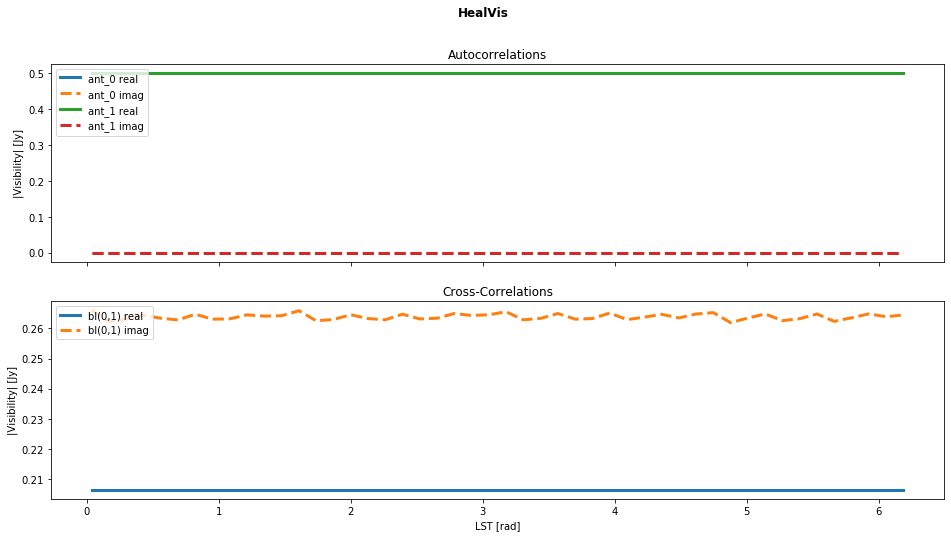

In [6]:
vis = simulator.simulate()
plot_blts(simulator)

`VisibilitySimulators` can also take point sources as inputs. `point_source_pos` is an array of each source position in (ra, dec). `point_source_flux` is an array of each source flux at each frequency in Jy. If an individual simulator is unable to simulate point-sources directly, an assumption is made whereby point sources are "diffused" onto a healpix map (and vice versa).

In [7]:
uvdata = myuvdata()
freqs = np.unique(uvdata.freq_array)
nbase = 5
nside = 2**nbase
psp = np.array([[0, uvdata.telescope_location_lat_lon_alt[0]]])
psf = np.array([[1.0]] * len(freqs))

simulator = HealVis(
    uvdata=uvdata,
    point_source_pos=psp,
    point_source_flux=psf,
    nside=nside
)

This visibility simulator is unable to explicitly simulate point sources. Adding point sources to diffuse pixels.


Finished: 1, Elapsed 0.00min, Remain 0.001hour, MaxRSS 0.18714GB
Finished: 2, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.192624GB
Finished: 3, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.192624GB
Finished: 4, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.192624GB
Finished: 5, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.192624GB
Finished: 6, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.192624GB
Finished: 7, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.192624GB
Finished: 8, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.192624GB
Finished: 9, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.192624GB
Finished: 10, Elapsed 0.01min, Remain 0.000hour, MaxRSS 0.192624GB
Finished: 11, Elapsed 0.01min, Remain 0.000hour, MaxRSS 0.192624GB
Finished: 12, Elapsed 0.01min, Remain 0.000hour, MaxRSS 0.192624GB
Finished: 13, Elapsed 0.01min, Remain 0.000hour, MaxRSS 0.192624GB
Finished: 14, Elapsed 0.01min, Remain 0.000hour, MaxRSS 0.192624GB
Finished: 15, Elapsed 0.01min, Remain 0.000hour, MaxRSS 0.192624GB
Finis

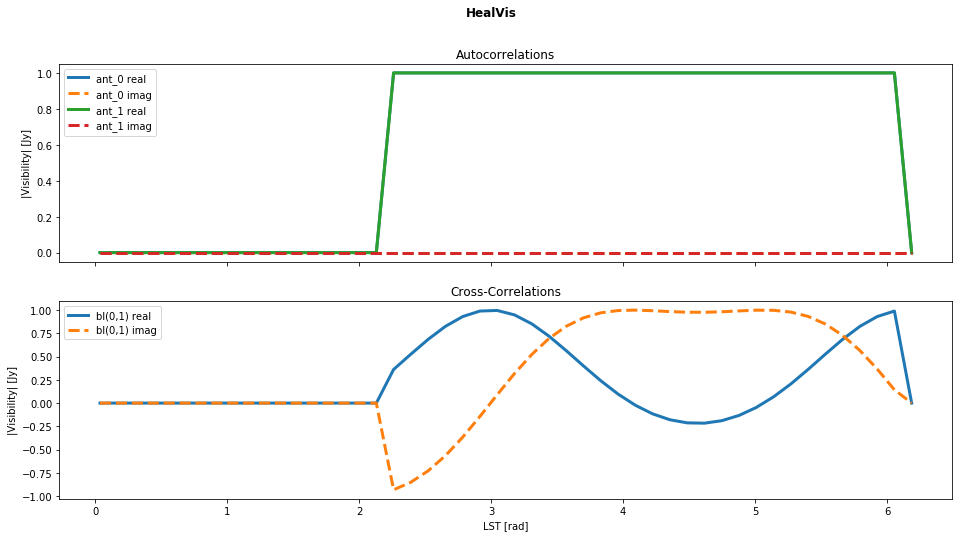

In [8]:
vis = simulator.simulate()
plot_blts(simulator)

## VisCPU

We could have also used `VisCPU` for this:

In [9]:
uvdata = myuvdata()
freqs = np.unique(uvdata.freq_array)
psp = np.array([[0, uvdata.telescope_location_lat_lon_alt[0]]])
psf = np.array([[1.0]] * len(freqs))

simulator = VisCPU(
    uvdata=uvdata,
    point_source_pos=psp,
    point_source_flux=psf
)

invalid value encountered in sqrt


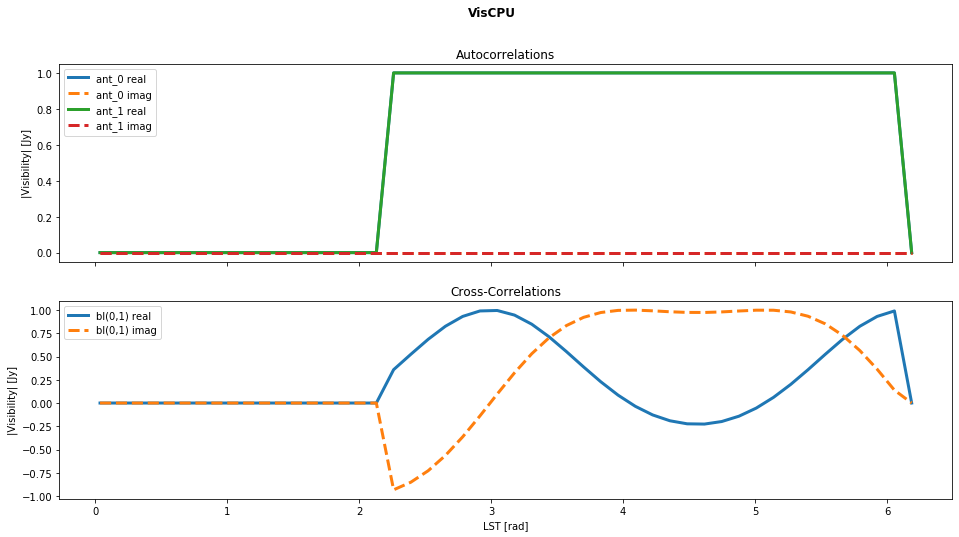

In [10]:
vis = simulator.simulate()
plot_blts(simulator)

In this, the beam was not set, and therefore the beam was assumed to be unity everywhere above the horizon. Each beam is of type `pyuvsim.analyticbeam.AnalyticBeam`, one for each antenna. 
If included, an extra list of `beam_ids` specifies which of the beams each antenna uses. Otherwise by default all antennas are assumed to use the zeroth entry in `beams`. So, we can create something like one beam being Gaussian and the other uniform:

In [11]:
uvdata = myuvdata()
freqs = np.unique(uvdata.freq_array)
nbase = 5
nside = 2**nbase
psp = np.array([[0, uvdata.telescope_location_lat_lon_alt[0]]])
psf = np.array([[1.0]] * len(freqs))
simulator = VisCPU(
    uvdata=uvdata,
    point_source_pos=psp,
    point_source_flux=psf,
    beams=[AnalyticBeam("gaussian", sigma=0.5), AnalyticBeam("uniform")],
    beam_ids=[0, 1],
)

invalid value encountered in sqrt


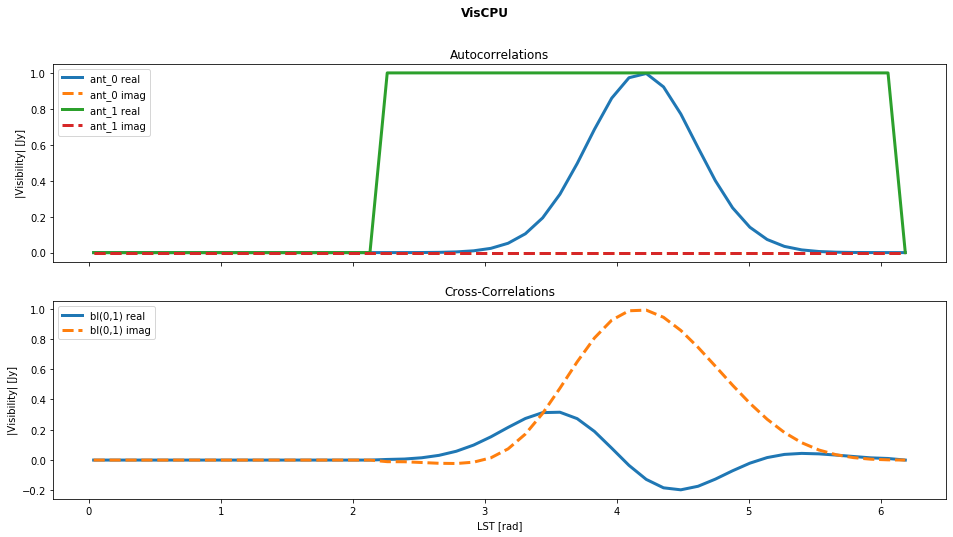

In [12]:
vis = simulator.simulate()
plot_blts(simulator)

## Comparing VisCPU & HealVis

To compare `VisCPU` and `Healvis` most accurately we must take into account how they sources differently. `VisCPU` treats the sky as a collection of point sources while `Healvis` must convert point sources into `HEALPix` maps. Error is introduced if a point source location is not at the center of a `HEALPix` pixel. To account for this we can relocate point sources to their nearest `HEALPix` centers before passing them in as arguments using `align_src_to_healpix`.

In [13]:
def align_src_to_healpix(point_source_pos, point_source_flux, nside=2**4):
    """Where the point sources will be placed when converted to healpix model
    
    Parameters
    ----------
    point_source_pos : ndarray
        Positions of point sources to be passed to a Simulator.
    point_source_flux : ndarray
        Corresponding fluxes of point sources at each frequency.
    nside : int
        Healpy nside parameter.
        

    Returns
    -------
    new_pos: ndarray
        Point sources positioned at their nearest healpix centers.
    new_flux: ndarray
        Corresponding new flux values.       
    """
    
    hmap = np.zeros((len(point_source_flux), healpy.nside2npix(nside)))

    # Get which pixel every point source lies in.
    pix = healpy.ang2pix(nside, np.pi/2 - point_source_pos[:, 1], point_source_pos[:, 0])

    hmap[:, pix] += point_source_flux / healpy.nside2pixarea(nside)
    nside = healpy.get_nside(hmap[0])
    ra, dec = healpy.pix2ang(nside, np.arange(len(hmap[0])), lonlat=True)
    flux = hmap * healpy.nside2pixarea(nside)
    return np.array([ra*np.pi/180, dec*np.pi/180]).T, flux

### Multiple Point Sources

In [14]:
uvdata = myuvdata(nants=3)
uvdata1 = myuvdata(nants=3)
freqs = np.unique(uvdata.freq_array)
nbase = 5
nside = 2**nbase

psp = np.array([[0, uvdata.telescope_location_lat_lon_alt[0] + np.pi/4],
                [0, uvdata.telescope_location_lat_lon_alt[0]]])
psf = np.array([[1.0, 1.0]] * len(freqs))
psp, psf = align_src_to_healpix(psp, psf, nside)

viscpu_sim = VisCPU(
    uvdata=uvdata,
    point_source_pos=psp,
    point_source_flux=psf
)

healvis_sim = HealVis(
    uvdata=uvdata1,
    sky_freqs=freqs,
    point_source_pos=psp,
    point_source_flux=psf,
    nside=nside
)

This visibility simulator is unable to explicitly simulate point sources. Adding point sources to diffuse pixels.


invalid value encountered in sqrt


Finished: 1, Elapsed 0.00min, Remain 0.001hour, MaxRSS 0.197784GB
Finished: 2, Elapsed 0.00min, Remain 0.001hour, MaxRSS 0.203468GB
Finished: 3, Elapsed 0.00min, Remain 0.001hour, MaxRSS 0.203468GB
Finished: 4, Elapsed 0.00min, Remain 0.001hour, MaxRSS 0.203468GB
Finished: 5, Elapsed 0.00min, Remain 0.001hour, MaxRSS 0.203468GB
Finished: 6, Elapsed 0.01min, Remain 0.001hour, MaxRSS 0.203468GB
Finished: 7, Elapsed 0.01min, Remain 0.001hour, MaxRSS 0.203468GB
Finished: 8, Elapsed 0.01min, Remain 0.001hour, MaxRSS 0.203468GB
Finished: 9, Elapsed 0.01min, Remain 0.001hour, MaxRSS 0.203468GB
Finished: 10, Elapsed 0.01min, Remain 0.001hour, MaxRSS 0.203468GB
Finished: 11, Elapsed 0.01min, Remain 0.001hour, MaxRSS 0.203468GB
Finished: 12, Elapsed 0.01min, Remain 0.001hour, MaxRSS 0.203468GB
Finished: 13, Elapsed 0.01min, Remain 0.000hour, MaxRSS 0.203468GB
Finished: 14, Elapsed 0.01min, Remain 0.000hour, MaxRSS 0.203468GB
Finished: 15, Elapsed 0.01min, Remain 0.000hour, MaxRSS 0.203468GB
Fini

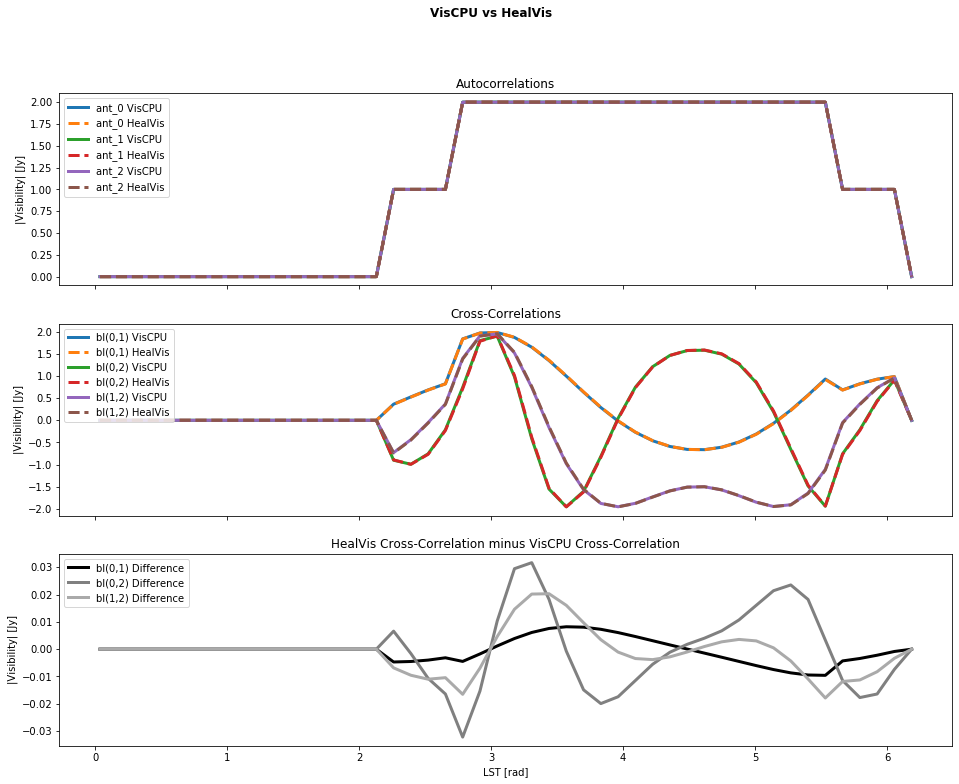

In [15]:
viscpu = viscpu_sim.simulate()
healvis = healvis_sim.simulate()
compare_blts(viscpu_sim, healvis_sim)

### Half Uniform Sky

In [16]:
uvdata = myuvdata(nants=3)
uvdata1 = myuvdata(nants=3)
freqs = np.unique(uvdata.freq_array)
nbase = 4
nside = 2**nbase
I_sky = half_uniform_sky()

viscpu_sim = VisCPU(
    uvdata=uvdata1,
    sky_intensity=I_sky
)

healvis_sim = HealVis(
    uvdata=uvdata,
    sky_intensity=I_sky
)

invalid value encountered in sqrt


Finished: 1, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.153368GB
Finished: 12, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.158308GB
Finished: 2, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.158308GB
Finished: 3, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.158308GB
Finished: 4, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.158308GB
Finished: 5, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.158308GB
Finished: 6, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.158308GB
Finished: 7, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.158308GB
Finished: 8, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.158308GB
Finished: 9, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.158308GB
Finished: 10, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.158308GB
Finished: 11, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.158308GB
Finished: 13, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.158308GB
Finished: 14, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.158308GB
Finished: 15, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.158308GB
Fini

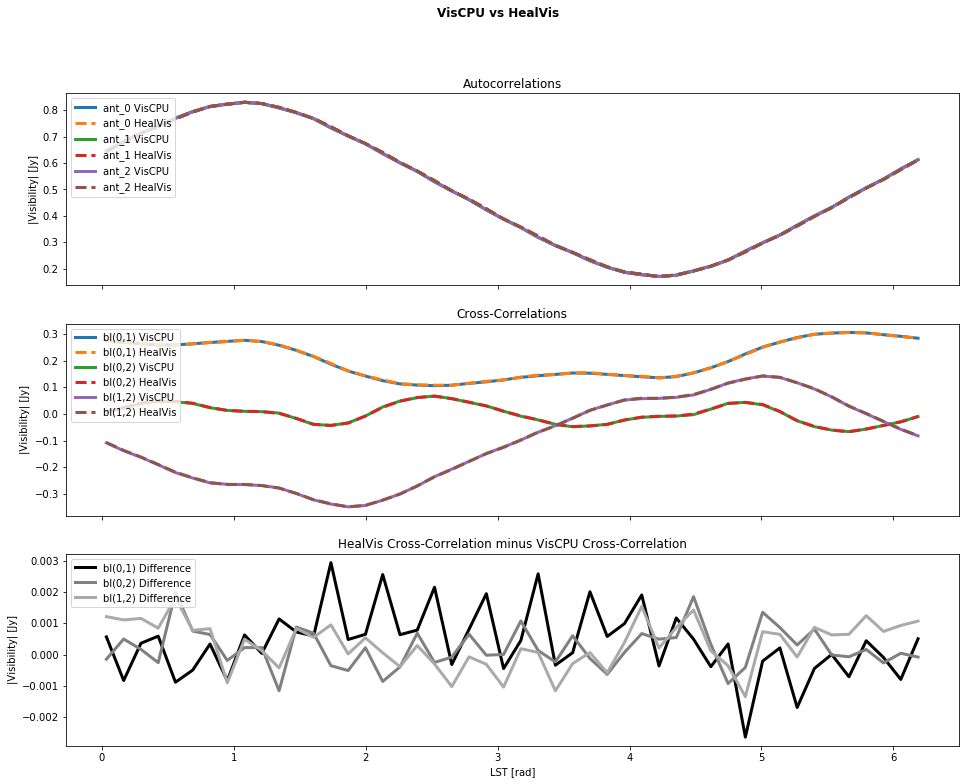

In [17]:
viscpu = viscpu_sim.simulate()
healvis = healvis_sim.simulate()
compare_blts(viscpu_sim, healvis_sim)

### Airy Beams

In [18]:
uvdata = myuvdata(nants=3)
uvdata1 = myuvdata(nants=3)
freqs = np.unique(uvdata.freq_array)
nbase = 4
nside = 2**nbase

psp = np.array([[0, uvdata.telescope_location_lat_lon_alt[0]]])
psf = np.array([[1.0]] * len(freqs))

psp, psf = align_src_to_healpix(psp, psf, nside)

viscpu_sim = VisCPU(
    uvdata=uvdata,
    point_source_pos=psp,
    point_source_flux=psf,
    beams=[AnalyticBeam("airy", diameter=1.25)]
)

healvis_sim = HealVis(
    uvdata=uvdata1,
    point_source_pos=psp,
    point_source_flux=psf,
    beams=[AnalyticBeam("airy", diameter=1.25)],
    nside=nside
)

This visibility simulator is unable to explicitly simulate point sources. Adding point sources to diffuse pixels.


invalid value encountered in sqrt


Finished: 1, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.159012GB
Finished: 7, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.164224GB
Finished: 2, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.164224GB
Finished: 3, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.164224GB
Finished: 4, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.164224GB
Finished: 5, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.164224GB
Finished: 6, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.164224GB
Finished: 8, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.164224GB
Finished: 9, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.164224GB
Finished: 10, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.164224GB
Finished: 11, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.164224GB
Finished: 12, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.164224GB
Finished: 13, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.164224GB
Finished: 14, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.164224GB
Finished: 15, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.164224GB
Fini

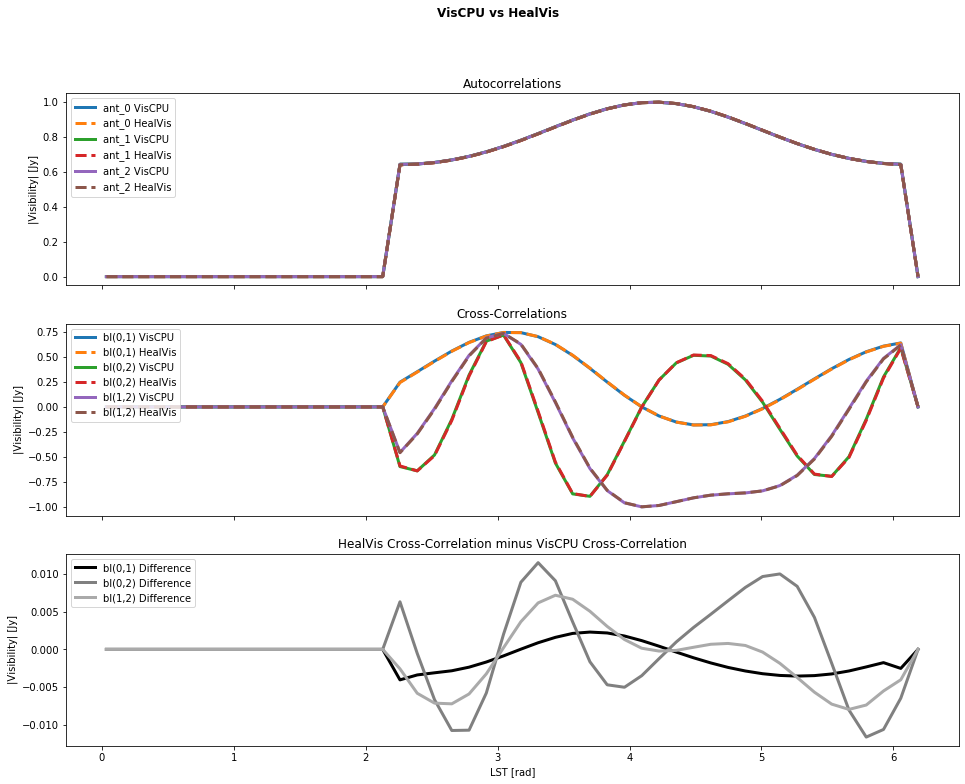

In [19]:
viscpu = viscpu_sim.simulate()
healvis = healvis_sim.simulate()
compare_blts(viscpu_sim, healvis_sim)

### All Together

In [20]:
uvdata = myuvdata(nants=3)
uvdata1 = myuvdata(nants=3)
freqs = np.unique(uvdata.freq_array)
nbase = 5
nside = 2**nbase

psp = np.array([[0, uvdata.telescope_location_lat_lon_alt[0] + np.pi/4],
                [0, uvdata.telescope_location_lat_lon_alt[0]]])
psf = np.array([[1.0, 1.0]] * len(freqs))
psp, psf = align_src_to_healpix(psp, psf, nside)

viscpu_sim = VisCPU(
    uvdata=uvdata,
    sky_intensity=half_uniform_sky(nbase),
    point_source_pos=psp,
    point_source_flux=psf,
    beams=[AnalyticBeam("airy", diameter=1.25)]
)

healvis_sim = HealVis(
    uvdata=uvdata1,
    sky_intensity=half_uniform_sky(nbase),
    point_source_pos=psp,
    point_source_flux=psf,
    beams=[AnalyticBeam("airy", diameter=1.25)],
    nside=nside
)

This visibility simulator is unable to explicitly simulate point sources. Adding point sources to diffuse pixels.


invalid value encountered in sqrt


Finished: 1, Elapsed 0.00min, Remain 0.001hour, MaxRSS 0.162332GB
Finished: 2, Elapsed 0.00min, Remain 0.001hour, MaxRSS 0.16826GB
Finished: 3, Elapsed 0.00min, Remain 0.001hour, MaxRSS 0.16826GB
Finished: 4, Elapsed 0.00min, Remain 0.001hour, MaxRSS 0.16826GB
Finished: 5, Elapsed 0.00min, Remain 0.001hour, MaxRSS 0.16826GB
Finished: 6, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.16826GB
Finished: 7, Elapsed 0.00min, Remain 0.000hour, MaxRSS 0.16826GB
Finished: 8, Elapsed 0.01min, Remain 0.000hour, MaxRSS 0.16826GB
Finished: 9, Elapsed 0.01min, Remain 0.000hour, MaxRSS 0.16826GB
Finished: 10, Elapsed 0.01min, Remain 0.000hour, MaxRSS 0.16826GB
Finished: 11, Elapsed 0.01min, Remain 0.000hour, MaxRSS 0.16826GB
Finished: 12, Elapsed 0.01min, Remain 0.000hour, MaxRSS 0.16826GB
Finished: 13, Elapsed 0.01min, Remain 0.000hour, MaxRSS 0.16826GB
Finished: 14, Elapsed 0.01min, Remain 0.000hour, MaxRSS 0.16826GB
Finished: 15, Elapsed 0.01min, Remain 0.000hour, MaxRSS 0.16826GB
Finished: 16, Elap

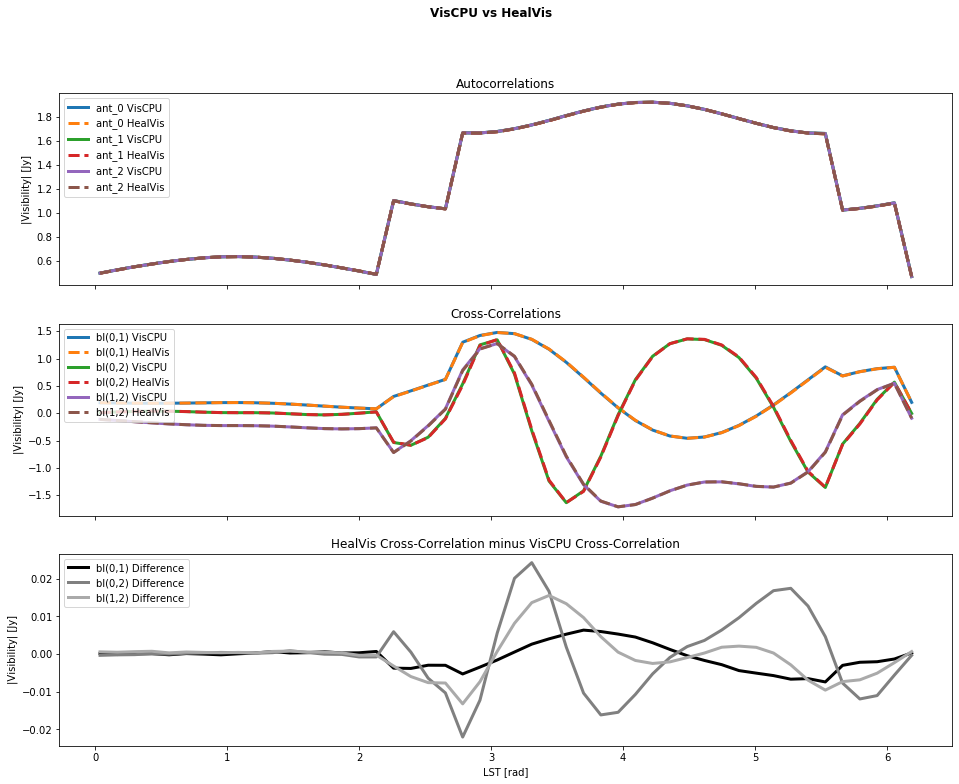

In [21]:
viscpu = viscpu_sim.simulate()
healvis = healvis_sim.simulate()
compare_blts(viscpu_sim, healvis_sim)

## Example HERA Simulation

In this section, we show how one might simulate for a "realistic" array layout, taking the initial HERA37 layout as an example.

In [22]:
NTIMES = 48

# Read in antenna positions from file
antpos_array = np.genfromtxt("data/antenna_positions_37.txt")
ants = {i: pos for i, pos in enumerate(antpos_array)}

uvdata = io.empty_uvdata(
    ants=ants,
    nfreq=5,
    integration_time=sday.to('s')/NTIMES,
    ntimes=NTIMES
)

In [23]:
# pygsm required
nbase = 4
nside = 2**nbase
npix = nside**2 * 12
freqs = np.unique(uvdata.freq_array)

# Construct a GSM and convert it from [K] to [Jy/Sr]
I_sky_Kelvin = gsm_shell(Nside=nside, freqs=freqs)
pix_area = 4 * np.pi / float(npix)
I_sky = I_sky_Kelvin / jy2Tsr(f=freqs, bm=pix_area)

# Native healvis format differs from VisibilitySimulators
I_sky = I_sky.T

In [24]:
healvis_sim = HealVis(
    uvdata=uvdata,
    sky_intensity=I_sky,
)

In [25]:
healvis = healvis_sim.simulate()

Finished: 1, Elapsed 0.01min, Remain 0.006hour, MaxRSS 0.313412GB
Finished: 2, Elapsed 0.02min, Remain 0.006hour, MaxRSS 0.318356GB
Finished: 3, Elapsed 0.03min, Remain 0.007hour, MaxRSS 0.318356GB
Finished: 4, Elapsed 0.04min, Remain 0.007hour, MaxRSS 0.318356GB
Finished: 5, Elapsed 0.05min, Remain 0.007hour, MaxRSS 0.318356GB
Finished: 6, Elapsed 0.06min, Remain 0.007hour, MaxRSS 0.318356GB
Finished: 7, Elapsed 0.07min, Remain 0.007hour, MaxRSS 0.318356GB
Finished: 8, Elapsed 0.08min, Remain 0.006hour, MaxRSS 0.318356GB
Finished: 9, Elapsed 0.09min, Remain 0.006hour, MaxRSS 0.318356GB
Finished: 10, Elapsed 0.09min, Remain 0.006hour, MaxRSS 0.318356GB
Finished: 11, Elapsed 0.10min, Remain 0.006hour, MaxRSS 0.318356GB
Finished: 12, Elapsed 0.12min, Remain 0.006hour, MaxRSS 0.318356GB
Finished: 13, Elapsed 0.13min, Remain 0.006hour, MaxRSS 0.318356GB
Finished: 14, Elapsed 0.14min, Remain 0.005hour, MaxRSS 0.318356GB
Finished: 15, Elapsed 0.15min, Remain 0.005hour, MaxRSS 0.318356GB
Fini

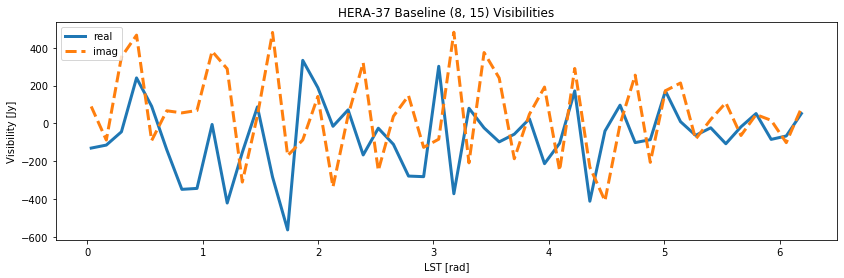

In [26]:
bl = (8, 15)
cross_ind = healvis_sim.uvdata.antpair2ind(bl)
cross_cor = healvis_sim.uvdata.data_array[cross_ind, 0, 0, 0]

lsts = np.sort(np.unique(healvis_sim.uvdata.lst_array))
plt.figure(figsize=(14,4))
plt.plot(lsts, np.real(cross_cor), label="real")
plt.plot(lsts, np.imag(cross_cor), linestyle="--", label="imag")

plt.title("HERA-37 Baseline {} Visibilities".format(bl))
plt.xlabel("LST [rad]")
plt.ylabel("Visibility [Jy]")
plt.legend()

## Creating a simulation from `pyuvsim` config

The interface is meant to be compatible with the `pyuvsim` config, so that their [configuration](https://pyuvsim.readthedocs.io/en/latest/parameter_files.html) can be used directly.

Here's our overall configuration:

In [27]:
!cat data/obsparam_example.yml

cat: data/obsparam_example.yml: No such file or directory


And the antenna position file (with just four antennas!):

In [28]:
!cat data/example_antpos_uvsim.csv

Name        Number   BeamID   E        N       U

ANT1        0        0        0.0000   0.0000  0.0000
ANT2        1        0        50.000   0.0000  0.0000
ANT3        2        0        0.0000   -50.00  0.0000
ANT4        3        0        26.000   -26.00  0.0000

And the telescope config, which has the beam information:

In [29]:
!cat data/example_telescope_uvsim.yaml

beam_paths:
  0: 'gaussian'
  1: 'airy'
diameter: 16
telescope_location: (-30.72152777777791, 21.428305555555557, 1073.0000000093132)
telescope_name: small_example

In [30]:
angles = healpy.pix2ang(2**4, np.arange(3072), lonlat=False)

psp = np.array([angles[0], angles[1]]).T
psf = np.array([np.random.normal(loc=10, scale=0.1, size=len(angles[0]))] * 11)

In [31]:
config_sim = VisCPU(
    obsparams = os.path.abspath("data/obsparam_example.yaml"),
    point_source_pos=psp,
    point_source_flux=psf,
)

In [32]:
config_sim.simulate();

invalid value encountered in sqrt


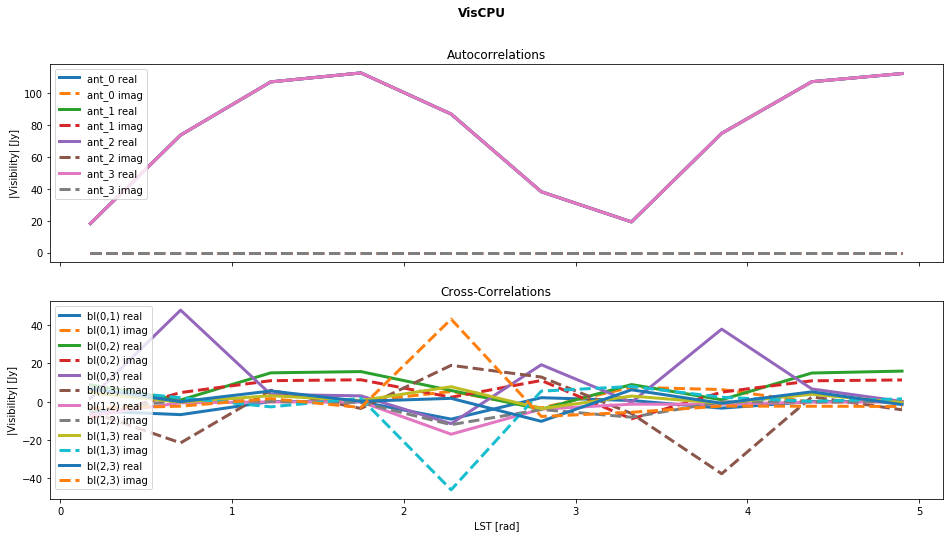

In [33]:
plot_blts(config_sim)